# Trend Finder
This notebook tries to identify trends in a crypto chart which indicate buy or sell signals to be used for automated trading. This is done by (1) creating a feature matrix which is (2) used as input for a deep learning network based on TensorFlow.
See the following video regarding the used TensorFlow approach: https://www.youtube.com/watch?v=-vHQub0NXI4

In [1]:
# Import python libraries
from statistics import mean
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from IPython import display
%matplotlib inline

In [2]:
# Load chart from file
chart = pd.read_csv('./gemini_ETHUSD_2020_1min.csv', skiprows=[0])  # Read file with chart
chart = chart.sort_values(by=['Date']) # Since it is in a reverse order, sort the chart ascendingly
chart = chart.reset_index(drop=True)   # Reset old index
chart.head(10)

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1577836800000,2020-01-01 00:00:00,ETHUSD,128.84,128.84,128.74,128.74,0.010000
1,1577836860000,2020-01-01 00:01:00,ETHUSD,128.74,128.74,128.74,128.74,0.000000
2,1577836920000,2020-01-01 00:02:00,ETHUSD,128.74,128.74,128.74,128.74,0.000000
3,1577836980000,2020-01-01 00:03:00,ETHUSD,128.74,128.74,128.74,128.74,0.000000
4,1577837040000,2020-01-01 00:04:00,ETHUSD,128.74,128.74,128.49,128.50,4.039458
5,1577837100000,2020-01-01 00:05:00,ETHUSD,128.50,128.50,128.50,128.50,0.000000
6,1577837160000,2020-01-01 00:06:00,ETHUSD,128.50,128.50,128.50,128.50,0.000000
7,1577837220000,2020-01-01 00:07:00,ETHUSD,128.50,128.50,128.41,128.41,1.627411
8,1577837280000,2020-01-01 00:08:00,ETHUSD,128.41,128.41,128.41,128.41,0.000000
9,1577837340000,2020-01-01 00:09:00,ETHUSD,128.41,128.41,128.41,128.41,0.000000


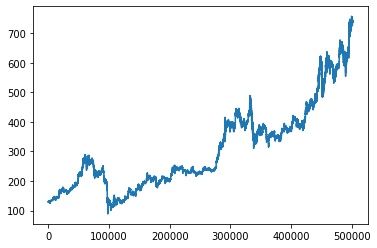

In [3]:
# Plot chart
plt.plot(chart['Open'])

## Generate feature matrix
The feature matrix contains for every price in the chart the growth since the last 1, 2, 4, 8, ..., 524288 prices. These are the features. Furthermore, it contains for every price in the chart the growth till the next 1, 2, 4, 8, ..., 524288 prices. The latter numbers are no features but they can be used as labels for training to predict the price in 1, 2, 4, 8, ..., 524288 prices.

In [4]:
def generateFeatureMatrix(chart):
    
    date = []
    price = []
    last_1 = []
    last_2 = []
    last_4 = []
    last_8 = []
    last_16 = []
    last_32 = []
    last_64 = []
    last_128 = []
    last_256 = []
    last_512 = []
    last_1024 = []
    last_2048 = []
    last_4096 = []
    last_8192 = []
    last_16348 = []
    last_32768 = []
    last_65536 = []
    last_131072 = []
    last_262144 = []
    last_524288 = []
    next_1 = []
    next_2 = []
    next_4 = []
    next_8 = []
    next_16 = []
    next_32 = []
    next_64 = []
    next_128 = []
    next_256 = []
    next_512 = []
    next_1024 = []
    next_2048 = []
    next_4096 = []
    next_8192 = []
    next_16348 = []
    next_32768 = []
    next_65536 = []
    next_131072 = []
    next_262144 = []
    next_524288 = []
    
    i = 0

    rows = chart.shape[0]
    print("Rows:", rows)
    
    # Go through all rows and calculate for each row the growth since or till other prices before or after the current row
    i = 0
    while i < rows:
        if(i % 10000 == 0): print("Row number:", i) # Write every 10000th row index to show progress
        date.append(chart.iloc[i, 1])
        current_price = chart.iloc[i, 3]
        price.append(current_price)
        
        value = np.nan
        if i > 0:
            value = current_price / chart.iloc[i - 1, 3]
        last_1.append(value)

        value = np.nan
        if i > 1:
            value = current_price / chart.iloc[i - 2, 3]
        last_2.append(value)

        value = np.nan
        if i > 3:
            value = current_price / chart.iloc[i - 4, 3]
        last_4.append(value)

        value = np.nan
        if i > 7:
            value = current_price / chart.iloc[i - 8, 3]
        last_8.append(value)
        
        value = np.nan
        if i > 15:
            value = current_price / chart.iloc[i - 16, 3]
        last_16.append(value)
        
        value = np.nan
        if i > 31:
            value = current_price / chart.iloc[i - 32, 3]
        last_32.append(value)
        
        value = np.nan
        if i > 63:
            value = current_price / chart.iloc[i - 64, 3]
        last_64.append(value)
        
        value = np.nan
        if i > 127:
            value = current_price / chart.iloc[i - 128, 3]
        last_128.append(value)
        
        value = np.nan
        if i > 255:
            value = current_price / chart.iloc[i - 256, 3]
        last_256.append(value)
        
        value = np.nan
        if i > 511:
            value = current_price / chart.iloc[i - 512, 3]
        last_512.append(value)
        
        value = np.nan
        if i > 1023:
            value = current_price / chart.iloc[i - 1024, 3]
        last_1024.append(value)
        
        value = np.nan
        if i > 2047:
            value = current_price / chart.iloc[i - 2048, 3]
        last_2048.append(value)
        
        value = np.nan
        if i > 4095:
            value = current_price / chart.iloc[i - 4096, 3]
        last_4096.append(value)
        
        value = np.nan
        if i > 8191:
            value = current_price / chart.iloc[i - 8192, 3]
        last_8192.append(value)
        
        value = np.nan
        if i > 16347:
            value = current_price / chart.iloc[i - 16348, 3]
        last_16348.append(value)
        
        value = np.nan
        if i > 32767:
            value = current_price / chart.iloc[i - 32768, 3]
        last_32768.append(value)

        value = np.nan
        if i > 65535:
            value = current_price / chart.iloc[i - 65536, 3]
        last_65536.append(value)

        value = np.nan
        if i > 131071:
            value = current_price / chart.iloc[i - 131072, 3]
        last_131072.append(value)

        value = np.nan
        if i > 262143:
            value = current_price / chart.iloc[i - 262144, 3]
        last_262144.append(value)

        value = np.nan
        if i > 524287:
            value = current_price / chart.iloc[i - 524288, 3]
        last_524288.append(value)

        value = np.nan
        if i < (rows - 1):
            value = chart.iloc[i + 1, 3] / current_price
        next_1.append(value)        
        
        value = np.nan
        if i < (rows - 2):
            value = chart.iloc[i + 2, 3] / current_price
        next_2.append(value)        
        
        value = np.nan
        if i < (rows - 4):
            value = chart.iloc[i + 4, 3] / current_price
        next_4.append(value)        
        
        value = np.nan
        if i < (rows - 8):
            value = chart.iloc[i + 8, 3] / current_price
        next_8.append(value)        
        
        value = np.nan
        if i < (rows - 16):
            value = chart.iloc[i + 16, 3] / current_price
        next_16.append(value)        
        
        value = np.nan
        if i < (rows - 32):
            value = chart.iloc[i + 32, 3] / current_price
        next_32.append(value)        
        
        value = np.nan
        if i < (rows - 64):
            value = chart.iloc[i + 64, 3] / current_price
        next_64.append(value)        
        
        value = np.nan
        if i < (rows - 128):
            value = chart.iloc[i + 128, 3] / current_price
        next_128.append(value)        
        
        value = np.nan
        if i < (rows - 256):
            value = chart.iloc[i + 256, 3] / current_price
        next_256.append(value)        
        
        value = np.nan
        if i < (rows - 512):
            value = chart.iloc[i + 512, 3] / current_price
        next_512.append(value)        
        
        value = np.nan
        if i < (rows - 1024):
            value = chart.iloc[i + 1024, 3] / current_price
        next_1024.append(value)        
        
        value = np.nan
        if i < (rows - 2048):
            value = chart.iloc[i + 2048, 3] / current_price
        next_2048.append(value)        
        
        value = np.nan
        if i < (rows - 4096):
            value = chart.iloc[i + 4096, 3] / current_price
        next_4096.append(value)        
        
        value = np.nan
        if i < (rows - 8192):
            value = chart.iloc[i + 8192, 3] / current_price
        next_8192.append(value)        
        
        value = np.nan
        if i < (rows - 16348):
            value = chart.iloc[i + 16348, 3] / current_price
        next_16348.append(value)        
        
        value = np.nan
        if i < (rows - 32768):
            value = chart.iloc[i + 32768, 3] / current_price
        next_32768.append(value)        
        
        value = np.nan
        if i < (rows - 65536):
            value = chart.iloc[i + 65536, 3] / current_price
        next_65536.append(value)        
        
        value = np.nan
        if i < (rows - 131072):
            value = chart.iloc[i + 131072, 3] / current_price
        next_131072.append(value)        
        
        value = np.nan
        if i < (rows - 262144):
            value = chart.iloc[i + 262144, 3] / current_price
        next_262144.append(value)        
        
        value = np.nan
        if i < (rows - 524288):
            value = chart.iloc[i + 524288, 3] / current_price
        next_524288.append(value)        
        
        i+=1   

    # Create the features matrix from the previously created lists
    feature_matrix = pd.DataFrame(list(zip(date, last_131072, last_65536, last_32768, last_16348, last_8192, last_4096, last_2048, last_1024, last_512, last_256, last_128, last_64, last_32, last_16, last_8, last_4, last_2, last_1, price, next_1, next_2, next_4, next_8, next_16, next_32, next_64, next_128, next_256, next_512, next_1024, next_2048, next_4096, next_8192, next_16348, next_32768, next_65536, next_131072, next_262144, next_524288)), columns =['Date', 'Last 131072', 'Last 65536', 'Last 32768', 'Last 16348', 'Last 8192', 'Last 4096', 'Last 2048', 'Last 1024', 'Last 512', 'Last 256', 'Last 128', 'Last 64', 'Last 32', 'Last 16', 'Last 8', 'Last 4', 'Last 2', 'Last 1', 'Price', 'Next 1', 'Next 2', 'Next 4', 'Next 8', 'Next 16', 'Next 32', 'Next 64', 'Next 128', 'Next 256', 'Next 512', 'Next 1024', 'Next 2048', 'Next 4096', 'Next 8192', 'Next 16348', 'Next 32768', 'Next 65536', 'Next 131072', 'Next 262144', 'Next 524288'])            

    return feature_matrix

In [5]:
# Generate the feature matrix
feature_matrix = generateFeatureMatrix(chart)

Rows: 501133
Row number: 0
Row number: 10000
Row number: 20000
Row number: 30000
Row number: 40000
Row number: 50000
Row number: 60000
Row number: 70000
Row number: 80000
Row number: 90000
Row number: 100000
Row number: 110000
Row number: 120000
Row number: 130000
Row number: 140000
Row number: 150000
Row number: 160000
Row number: 170000
Row number: 180000
Row number: 190000
Row number: 200000
Row number: 210000
Row number: 220000
Row number: 230000
Row number: 240000
Row number: 250000
Row number: 260000
Row number: 270000
Row number: 280000
Row number: 290000
Row number: 300000
Row number: 310000
Row number: 320000
Row number: 330000
Row number: 340000
Row number: 350000
Row number: 360000
Row number: 370000
Row number: 380000
Row number: 390000
Row number: 400000
Row number: 410000
Row number: 420000
Row number: 430000
Row number: 440000
Row number: 450000
Row number: 460000
Row number: 470000
Row number: 480000
Row number: 490000
Row number: 500000


In [6]:
# Show feature matrix
feature_matrix.head()

,Date,Last 131072,Last 65536,Last 32768,Last 16348,Last 8192,Last 4096,Last 2048,Last 1024,Last 512,...,Next 1024,Next 2048,Next 4096,Next 8192,Next 16348,Next 32768,Next 65536,Next 131072,Next 262144,Next 524288
0,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.028563,1.005123,1.039894,1.092130,1.112232,1.241850,2.066982,1.119295,1.859438,NaN
1,2020-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.026332,1.004971,1.040702,1.092978,1.113096,1.242815,2.068588,1.119776,1.860882,NaN
2,2020-01-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.026332,1.004971,1.039537,1.093056,1.113096,1.242815,2.069365,1.119776,1.860882,NaN
3,2020-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.026332,1.004971,1.037595,1.092745,1.113096,1.242815,2.069365,1.120475,1.860882,NaN
4,2020-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.026332,1.004971,1.034643,1.092745,1.113096,1.242815,2.069365,1.118689,1.862358,NaN


In [7]:
# Copy feature matrix
feature_matrix_reduced=feature_matrix

# The next steps must be parameterized according to what shall be predicted (e.g., the price in 512 cycles)

# Reduce copied matrix by removing all rows with an empty field in the specified row
feature_matrix_reduced=feature_matrix_reduced.dropna(subset=['Last 131072'], axis=0)

# Reduce copied matrix by removing all rows with an empty field in the specified row
feature_matrix_reduced=feature_matrix_reduced.dropna(subset=['Next 512'], axis=0)

# Build the final feature matrix
feature_matrix_reduced = feature_matrix_reduced[['Last 131072', 'Last 65536', 'Last 32768', 'Last 16348', 'Last 8192', 'Last 4096', 'Last 2048', 'Last 1024', 'Last 512', 'Last 256', 'Last 128', 'Last 64', 'Last 32', 'Last 16', 'Last 8', 'Last 4', 'Last 2', 'Last 1', 'Price', 'Next 512']]
feature_matrix_reduced.head(10)

,Last 131072,Last 65536,Last 32768,Last 16348,Last 8192,Last 4096,Last 2048,Last 1024,Last 512,Last 256,Last 128,Last 64,Last 32,Last 16,Last 8,Last 4,Last 2,Last 1,Price,Next 512
131072,1.119295,0.541512,1.222015,1.056329,1.091921,1.017785,1.015993,1.008744,1.001111,1.007546,1.006983,1.007898,1.007757,1.006350,1.004738,1.001945,0.999515,0.997993,144.21,1.041537
131073,1.119776,0.541324,1.214081,1.058288,1.091542,1.017289,1.016500,1.008394,1.000764,1.007196,1.006634,1.007548,1.007830,1.006985,1.002364,1.001598,0.997647,0.999653,144.16,1.041898
131074,1.119776,0.541121,1.214081,1.060702,1.091542,1.018079,1.016500,1.008394,1.000764,1.007196,1.006634,1.007548,1.007830,1.006985,1.001459,0.999168,0.999653,1.000000,144.16,1.041898
131075,1.120475,0.541459,1.207922,1.062459,1.092224,1.018787,1.017134,1.009024,1.001388,1.008107,1.007262,1.009377,1.008459,1.007614,1.002014,0.998270,1.000624,1.000624,144.25,1.041248
131076,1.118689,0.540595,1.209337,1.064056,1.090482,1.017162,1.015513,1.007415,0.999792,1.007556,1.005656,1.007767,1.006851,1.004534,1.000625,0.998682,0.999029,0.998406,144.02,1.042911
131077,1.124358,0.543423,1.213302,1.067455,1.093965,1.022433,1.018756,1.010632,1.002985,1.010774,1.008868,1.011198,1.010067,1.007742,1.003821,1.002220,1.001594,1.003194,144.48,1.039590
131078,1.119144,0.540903,1.206865,1.063447,1.088892,1.017692,1.014032,1.005946,0.998334,1.006086,1.004190,1.006509,1.006579,1.003069,0.996742,0.997572,0.998542,0.995363,143.81,1.049788
131079,1.119144,0.540944,1.203632,1.065259,1.088892,1.017188,1.014032,1.005946,0.998334,1.006086,1.004190,1.006509,1.006579,1.001951,0.995225,0.996950,0.995363,1.000000,143.81,1.055838
131080,1.119383,0.542170,1.190098,1.064741,1.088362,1.016693,1.013538,1.006019,1.003631,1.007147,1.003701,1.006019,1.006089,1.001463,0.996741,0.998056,0.999513,0.999513,143.74,1.056004
131081,1.119695,0.542320,1.188068,1.065669,1.088665,1.016976,1.012464,1.007710,1.003910,1.007427,1.003980,1.006299,1.006369,0.999722,0.997364,0.995155,0.999791,1.000278,143.78,1.057379


In [8]:
# Create a training set
train_dataset = feature_matrix_reduced.sample(frac=0.8, random_state=42)

# Create a test set by taking all rows whixch are not part of the training set
test_dataset = feature_matrix_reduced.drop(train_dataset.index)

In [9]:
# Create the labels for the training set (Note: The label column is removed from the training set)
train_labels = train_dataset.pop('Next 512')

# Create the labels for the test set (Note: The label column is removed from the test set)
test_labels = test_dataset.pop('Next 512')

In [10]:
# Create and show statistics on the train set
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Last 131072,295639.0,1.469623,0.348092,0.694139,1.175719,1.513223,1.711633,2.590199
Last 65536,295639.0,1.284486,0.321042,0.521487,1.048073,1.292831,1.556707,2.373425
Last 32768,295639.0,1.165544,0.199938,0.719678,1.022726,1.132029,1.290732,1.794176
Last 16348,295639.0,1.079195,0.125183,0.740235,0.988418,1.070538,1.151907,1.692558
Last 8192,295639.0,1.040985,0.097502,0.678636,0.973993,1.028022,1.105335,1.365406
Last 4096,295639.0,1.020696,0.070980,0.700111,0.977978,1.012118,1.060095,1.304411
Last 2048,295639.0,1.010237,0.047641,0.781661,0.984273,1.005785,1.034632,1.227870
Last 1024,295639.0,1.005112,0.033421,0.789224,0.988324,1.003540,1.022866,1.183116
Last 512,295639.0,1.002529,0.023375,0.844187,0.991890,1.001767,1.013558,1.150609
Last 256,295639.0,1.001269,0.016847,0.857284,0.993860,1.000851,1.008452,1.133799


In [11]:
def norm(x):
    '''
    OUTPUT:
    Normed row values (normed values have typically benefits for machine learning)
    '''
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Create and train the model

In [12]:
def build_model():
    '''
    OUTPUT:
    model
    
    Description:
    Build the model
    '''
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

# Build the model
model = build_model()

In [13]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1280      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Shiow example batch (untrained, just used to check whether the model fits)
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.46560997],
       [ 0.22819456],
       [ 0.30949092],
       [ 0.11860391],
       [ 0.30622917],
       [ 0.06082726],
       [ 0.23705088],
       [ 0.19349855],
       [-0.38950834],
       [-0.27493998]], dtype=float32)

In [15]:
# Show example batch
example_batch.head()

,Last 131072,Last 65536,Last 32768,Last 16348,Last 8192,Last 4096,Last 2048,Last 1024,Last 512,Last 256,Last 128,Last 64,Last 32,Last 16,Last 8,Last 4,Last 2,Last 1,Price
289987,0.987214,0.699245,1.429832,3.440856,1.049785,1.226533,1.104321,0.986599,1.360441,0.532130,0.188824,0.338975,0.139742,0.417884,0.065169,0.133592,0.335264,-0.004994,0.034058
280300,0.367144,-0.328993,0.506374,0.830441,1.672887,2.055148,0.842998,0.298879,0.154866,0.521334,0.493964,1.164653,1.082212,1.401006,1.085442,1.337574,0.948907,1.329635,-0.475170
359678,-0.022771,-1.291078,-1.513207,-0.758014,-0.944661,-1.800749,-2.410272,-2.820312,-2.361650,-0.643993,0.779962,-0.495426,-0.297655,-0.030375,-0.340559,-0.835690,0.266216,-0.004994,-0.082037
389566,0.264334,-0.856731,-0.793050,0.099199,0.897294,0.168309,0.421010,-0.457577,0.067003,0.155282,0.262256,0.074040,0.061224,0.346107,-0.240087,-0.293141,-0.247887,-0.342255,0.232454
373655,0.009140,-1.509397,-0.957523,-1.524886,-0.842782,-1.017200,-1.438338,-0.970636,-1.812011,-1.039697,-0.487666,-0.173295,0.877114,0.074385,-0.968883,-0.245069,-0.572503,-0.747855,-0.101267


In [16]:
# Create cloass to show dots to visualize the progress (training takes long; shows that the program has not crashed)
class PrintDots(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
EPOCHS = 200

# Train the model and return a history
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDots()])


....................................................................................................
....................................................................................................

In [17]:
# Show history
hist=pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head(10)

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,0.003263,0.028572,0.003263,0.000610,0.019852,0.000610,0
1,0.000328,0.013696,0.000328,0.000238,0.011458,0.000238,1
2,0.000260,0.012305,0.000260,0.000183,0.010256,0.000183,2
3,0.000228,0.011512,0.000228,0.000285,0.013398,0.000285,3
4,0.000206,0.010983,0.000206,0.000230,0.011837,0.000230,4
5,0.000190,0.010489,0.000190,0.000184,0.010596,0.000184,5
6,0.000176,0.010114,0.000176,0.000165,0.009759,0.000165,6
7,0.000163,0.009697,0.000163,0.000170,0.010283,0.000170,7
8,0.000150,0.009321,0.000150,0.000257,0.012843,0.000257,8
9,0.000143,0.009064,0.000143,0.000117,0.007901,0.000117,9


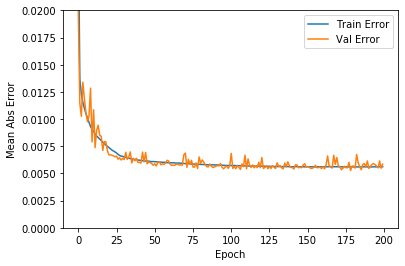

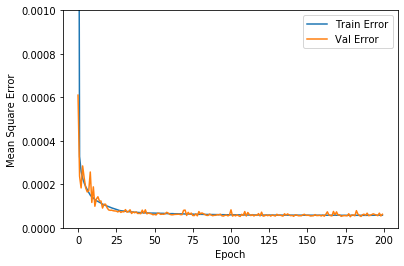

In [26]:
def plot_history(history):
    '''
    Description:
    Plot history of the training
    '''
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label='Val Error')
    plt.legend()
    plt.ylim([0,0.02])

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
            label='Val Error')
    plt.legend()
    plt.ylim([0,0.001])
    
plot_history(history)